# Cargar el modelo

In [10]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from src.models.efficientnet import EfficientNetB5Custom
from src.grad_cam import GradCAM
model_state = torch.load(r'models\OAI Mendeley\best_model_EfficientNetB5Custom_epoch_2.pt',map_location=torch.device('cpu'), weights_only=False)
model = EfficientNetB5Custom(num_classes=5, pretrained=False)
model.load_state_dict(model_state)
#model = torch.load(r'models\OAI Mendeley\best_model_EfficientNetB5_epoch_30.pt',map_location=torch.device('cpu'), weights_only=False)
model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

In [4]:
from torch.utils.data import DataLoader, Dataset
class gatosDataset(Dataset):
    def __init__(self, batch_size=32, transform=None, local=False, path="dataset/gatos/jpg"):
        if local:
            print("LOCAL MODE ENABLED")
        self.transform = transform
        self.data_path = path
        self.data = []
        self.batch_size = batch_size
        self.classes = sorted(os.listdir(self.data_path))  # Lista de clases
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_dataloader(self, shuffle=True):
        return DataLoader(self, batch_size=self.batch_size, shuffle=shuffle)
    

    import os



Training Epoch [1/10]:   0%|                                                                                          | 0/7 [00:00<?, ?it/s]c:\Users\34658\anaconda3\envs\tfg\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Training Epoch [1/10]:   0%|                                                                                          | 0/7 [00:15<?, ?it/s]


KeyboardInterrupt: 

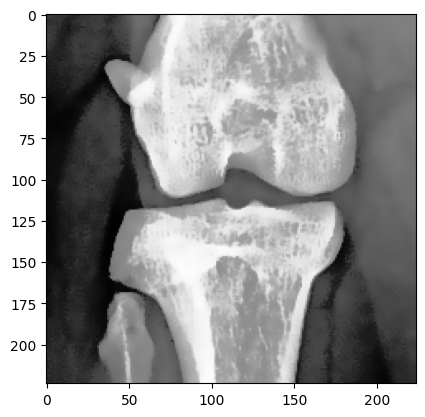

In [8]:

class HistogramEqualization:
    """Aplica ecualización de histograma para ajuste de contraste"""
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar ecualización de histograma por canal
        if len(img_np.shape) == 3:  # Imagen RGB
            img_eq = np.zeros_like(img_np)
            for i in range(3):
                img_eq[:,:,i] = cv2.equalizeHist(img_np[:,:,i])
        else:  # Imagen en escala de grises
            img_eq = cv2.equalizeHist(img_np)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_eq)

class BilateralFilter:
    """Aplica filtrado bilateral para suavizado preservando bordes"""
    def __init__(self, d=9, sigma_color=75, sigma_space=75):
        self.d = d  # Diámetro de cada vecindario de píxeles
        self.sigma_color = sigma_color  # Filtro sigma en el espacio de color
        self.sigma_space = sigma_space  # Filtro sigma en el espacio de coordenadas
    
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar filtro bilateral
        img_filtered = cv2.bilateralFilter(
            img_np, self.d, self.sigma_color, self.sigma_space)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_filtered)
import os
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.config import *
from src.data import *
from src.models.efficientnet import *
from src.utils import *
from src.train import train, train_model, test_model
from src.trainers.classification import Classification
from src.trainers.regresion import Regression

transform =  transforms.Compose([
            transforms.Resize((224, 224)), #Normalizar 
            HistogramEqualization(),
            BilateralFilter(),
            transforms.ToTensor(),
        ])
BATCH_SIZE = 10
LEARNING_RATE = 0.001
FACTOR = 0.001
L1 = 0.00
L2 = 0.00
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


val_dataset = gatosDataset(batch_size=BATCH_SIZE, transform=transform)
# Mosrar primera imagen
img, label = val_dataset[0]
plt.imshow(img.permute(1, 2, 0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Regression(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)
train_model(model,trainer,train_dataset=val_dataset, val_dataset=val_dataset, epochs=10, wdb=False, plot_loss=True, device=device)
test_model(model,val_dataset.get_dataloader(),trainer,device)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.config import *
from src.data import *
from src.models.efficientnet import *
from src.utils import *
from src.train import train, train_model, test_model
from src.trainers.classification import Classification
from src.trainers.regresion import Regression

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
class HistogramEqualization:
    """Aplica ecualización de histograma para ajuste de contraste"""
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar ecualización de histograma por canal
        if len(img_np.shape) == 3:  # Imagen RGB
            img_eq = np.zeros_like(img_np)
            for i in range(3):
                img_eq[:,:,i] = cv2.equalizeHist(img_np[:,:,i])
        else:  # Imagen en escala de grises
            img_eq = cv2.equalizeHist(img_np)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_eq)

class BilateralFilter:
    """Aplica filtrado bilateral para suavizado preservando bordes"""
    def __init__(self, d=9, sigma_color=75, sigma_space=75):
        self.d = d  # Diámetro de cada vecindario de píxeles
        self.sigma_color = sigma_color  # Filtro sigma en el espacio de color
        self.sigma_space = sigma_space  # Filtro sigma en el espacio de coordenadas
    
    def __call__(self, img):
        # Convertir PIL Image a numpy array
        img_np = np.array(img)
        
        # Aplicar filtro bilateral
        img_filtered = cv2.bilateralFilter(
            img_np, self.d, self.sigma_color, self.sigma_space)
            
        # Convertir de nuevo a PIL Image
        return Image.fromarray(img_filtered)

transform =  transforms.Compose([
            transforms.Resize((224, 224)), #Normalizar 
            HistogramEqualization(),
            BilateralFilter(),
            transforms.ToTensor(),
        ])
BATCH_SIZE = 10
LEARNING_RATE = 5
FACTOR = 0.001
L1 = 0.00
L2 = 0.00
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


val_dataset = gatosDataset(batch_size=BATCH_SIZE, transform=transform)
# Mosrar primera imagen
img, label = val_dataset[0]
plt.imshow(img.permute(1, 2, 0))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Regression(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)
test_model(model,val_dataset.get_dataloader(),trainer,device)

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
for batch in val_dataset.get_dataloader():
    images, labels = batch

    # Visualizar la imagen
    image = images[0].numpy().transpose(1, 2, 0)  # Convertir a formato HWC para matplotlib
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalizar a [0, 1]
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    with torch.no_grad():
        outputs = model(images)
        print(outputs*4)

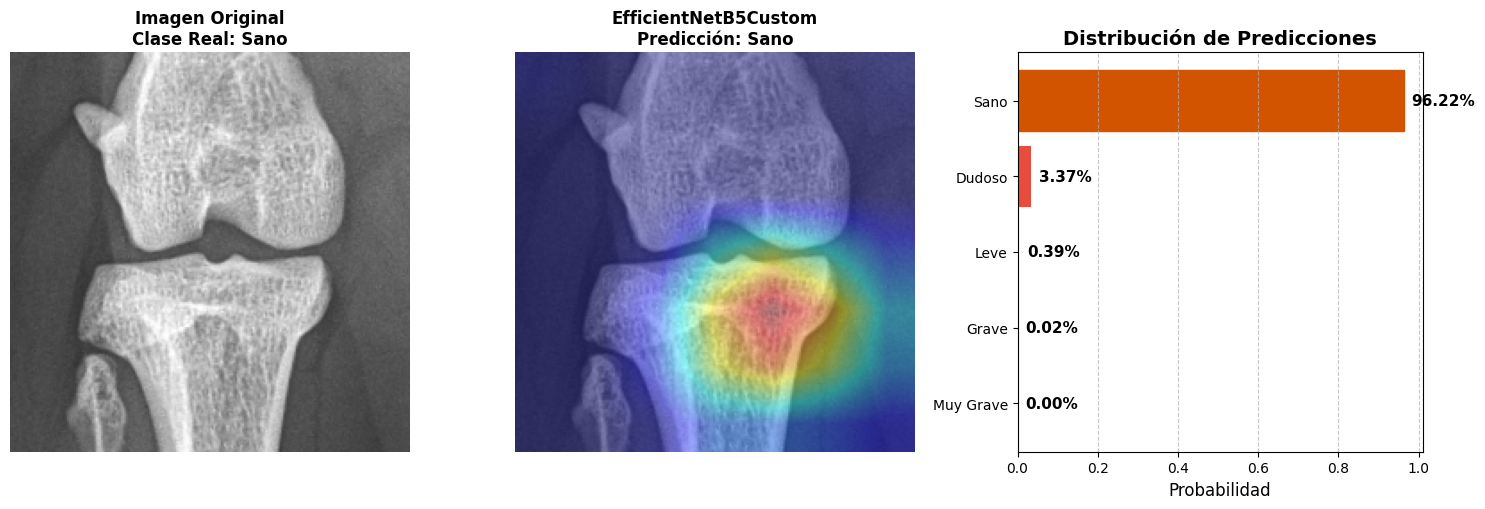

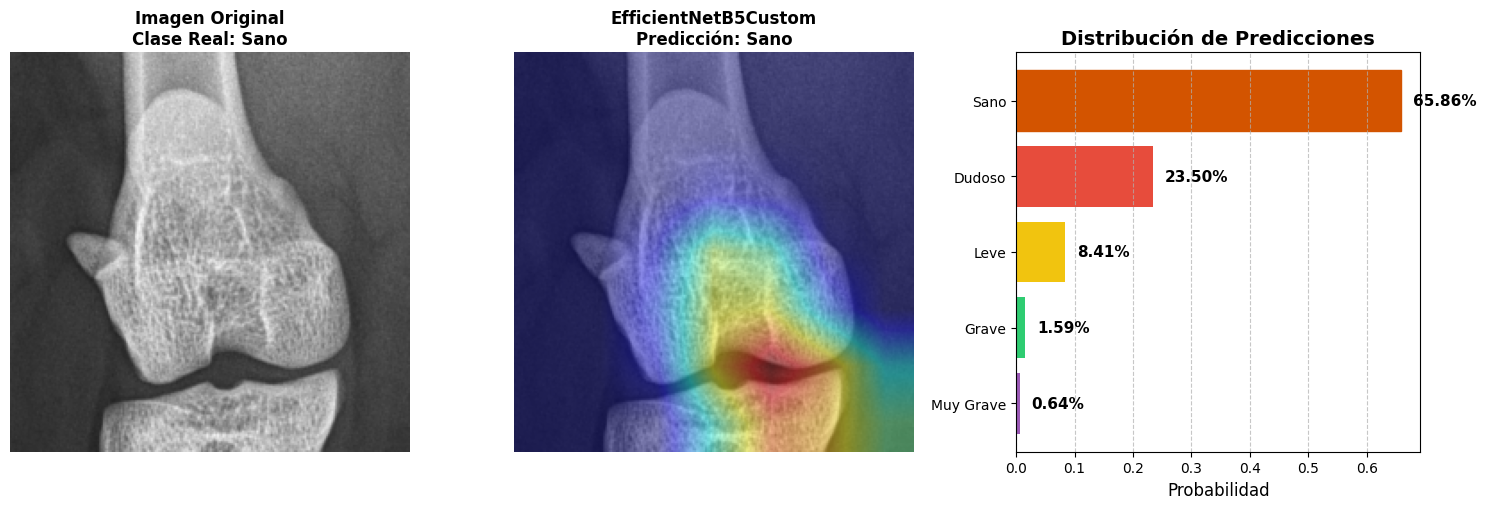

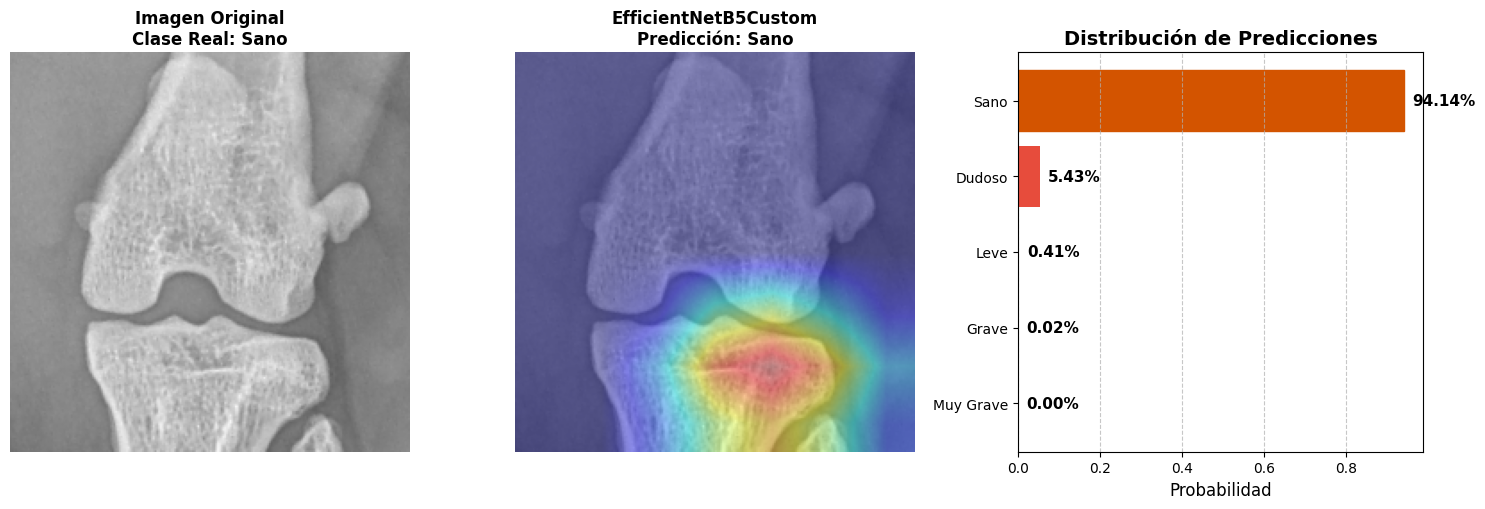

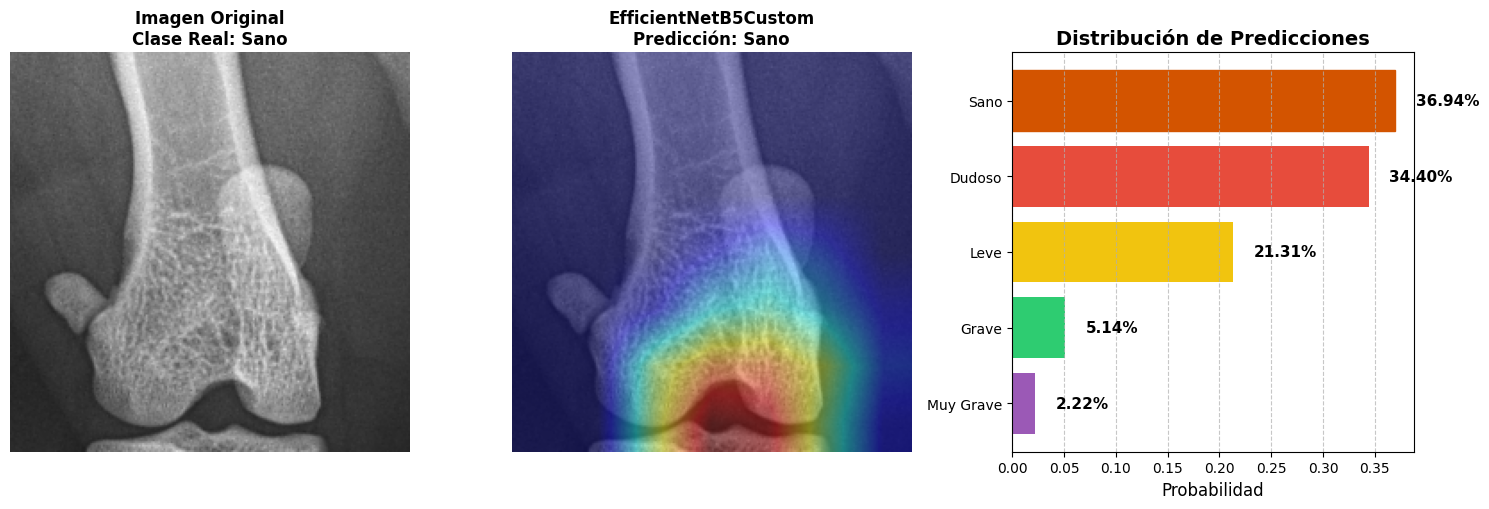

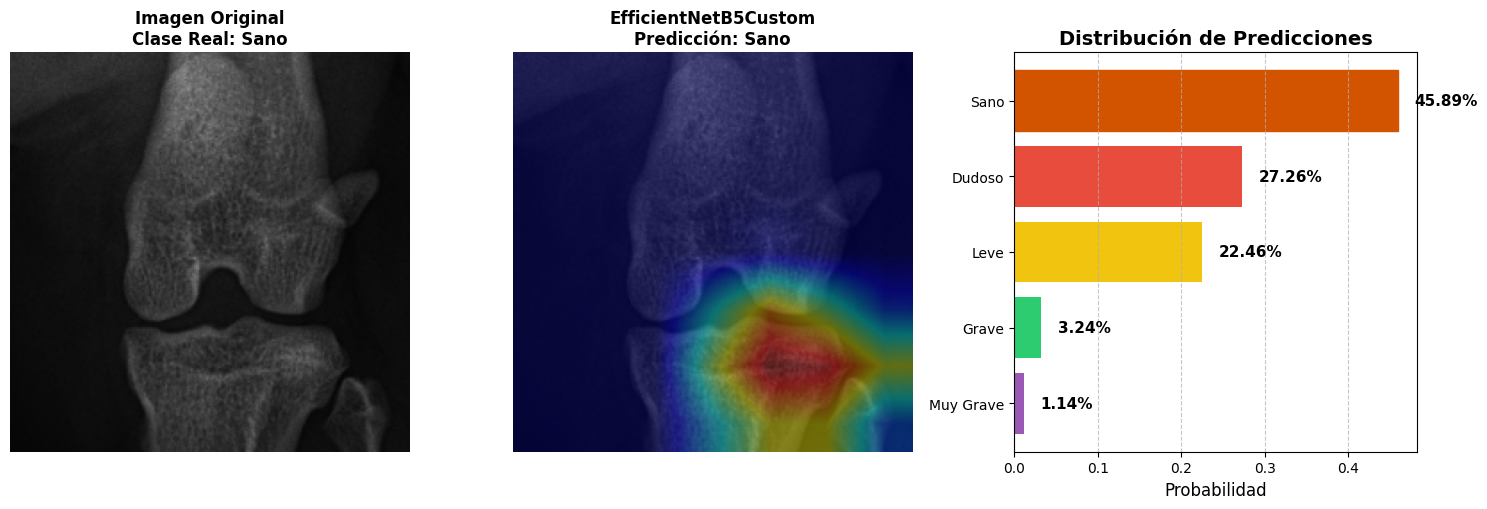

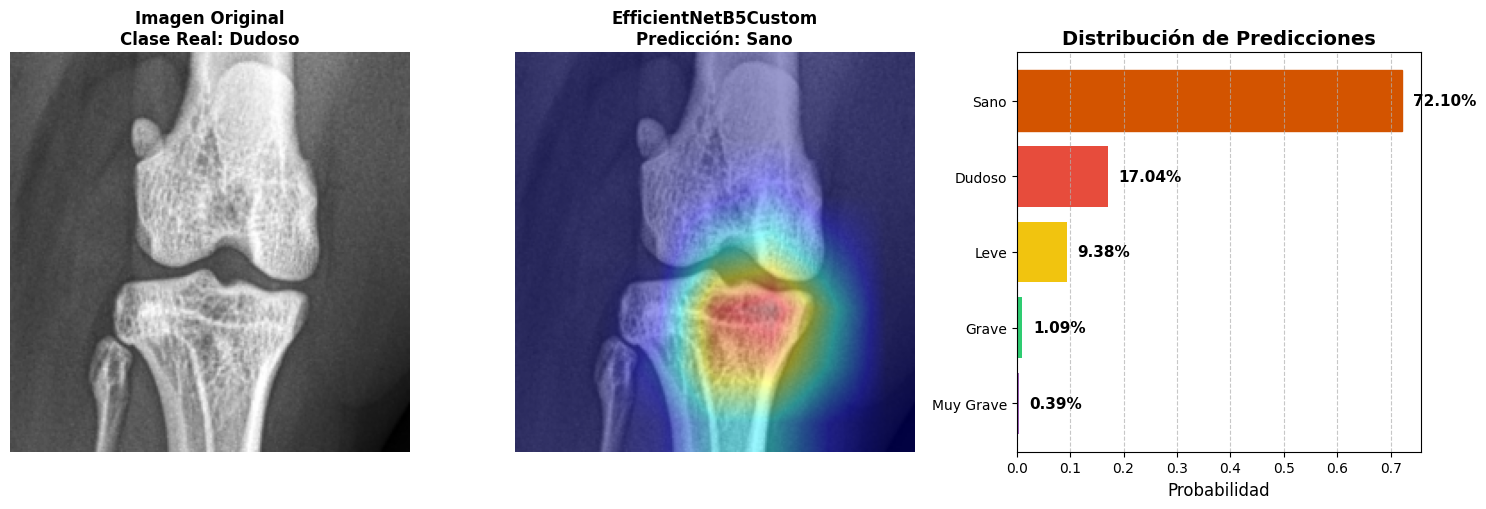

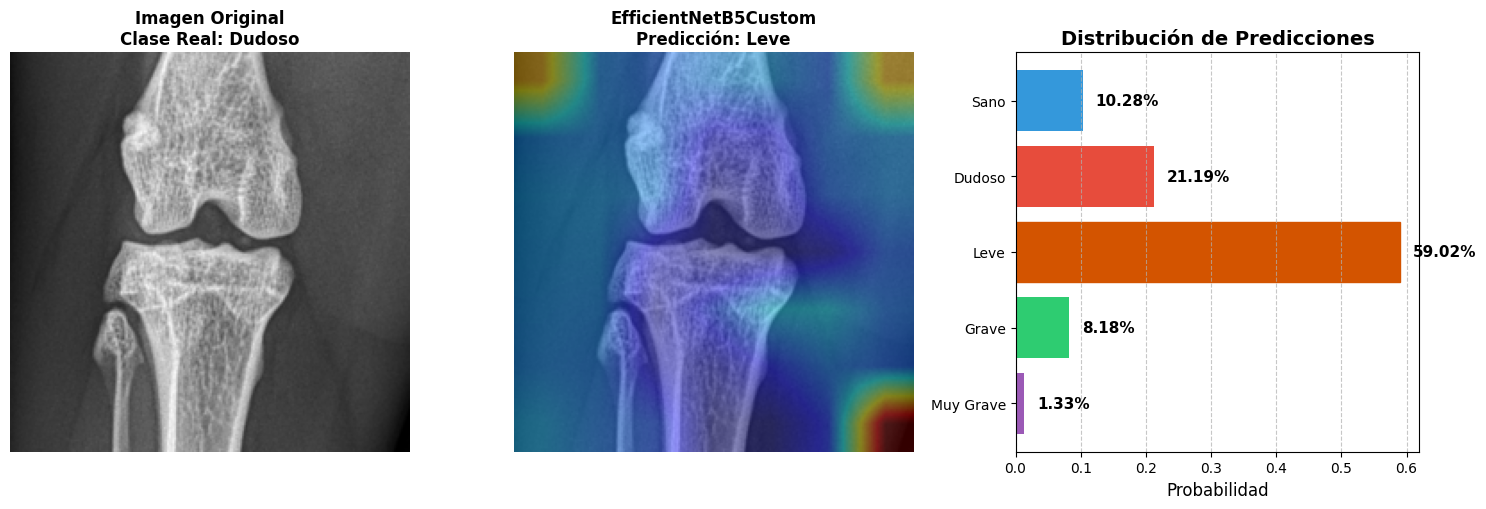

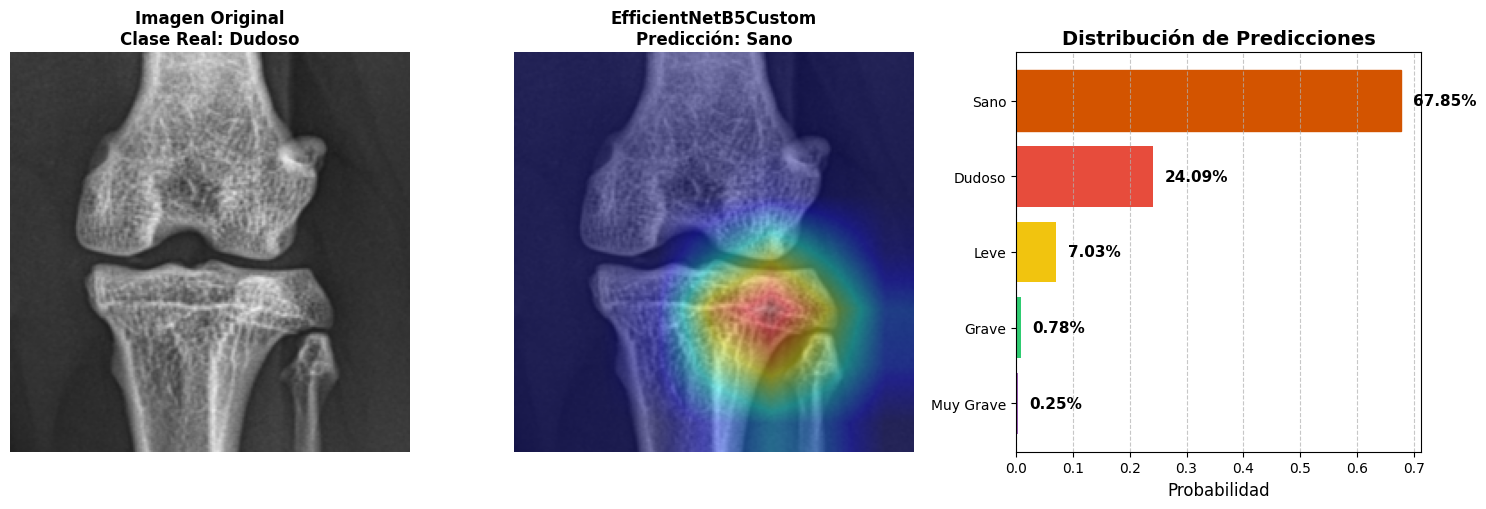

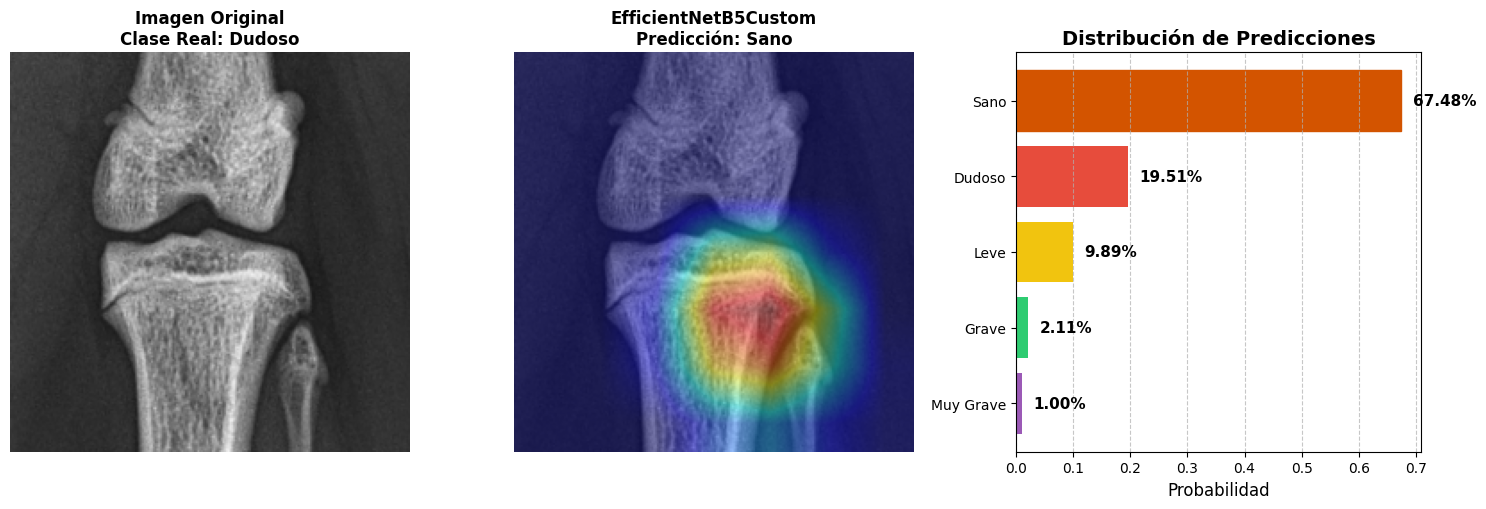

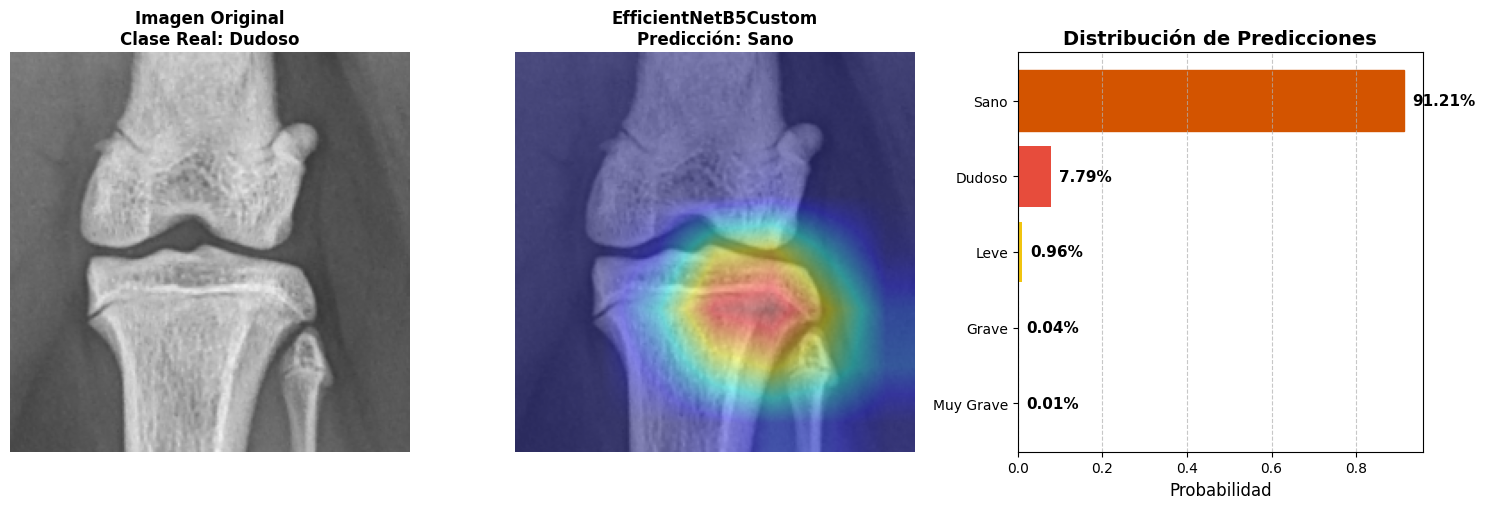

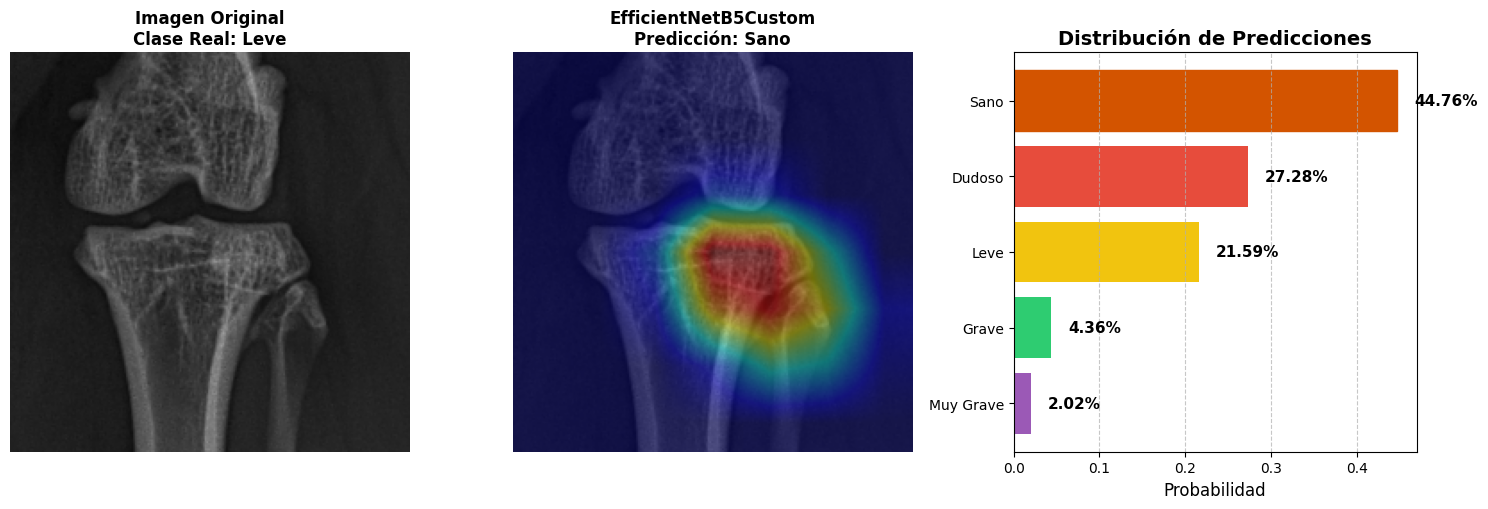

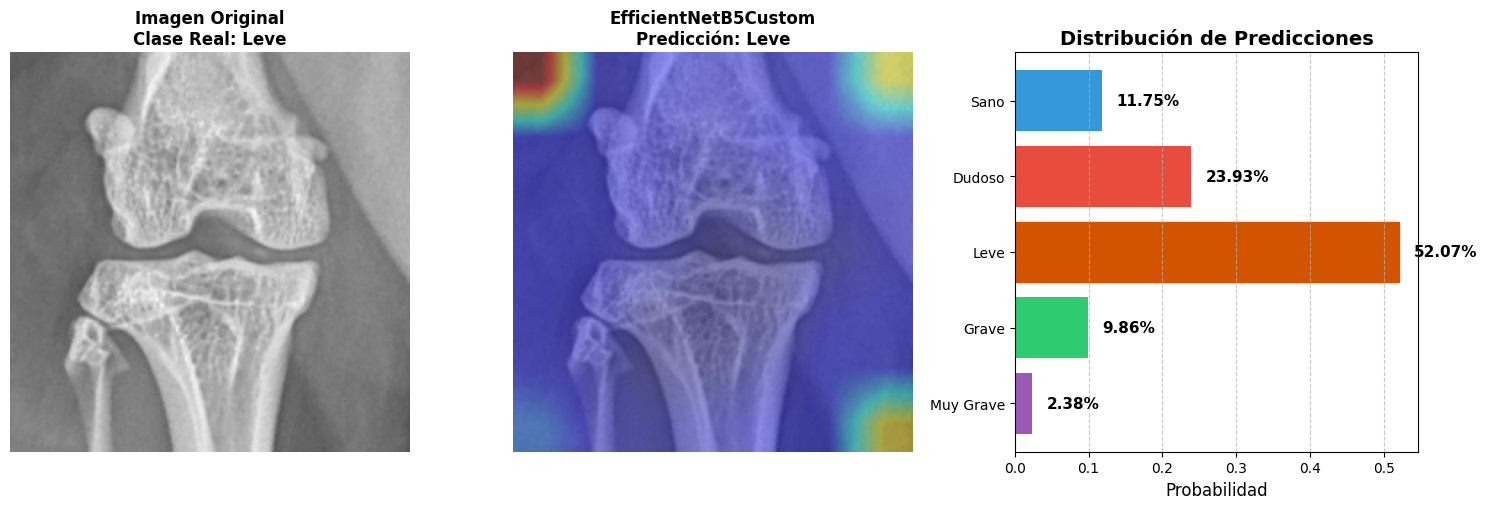

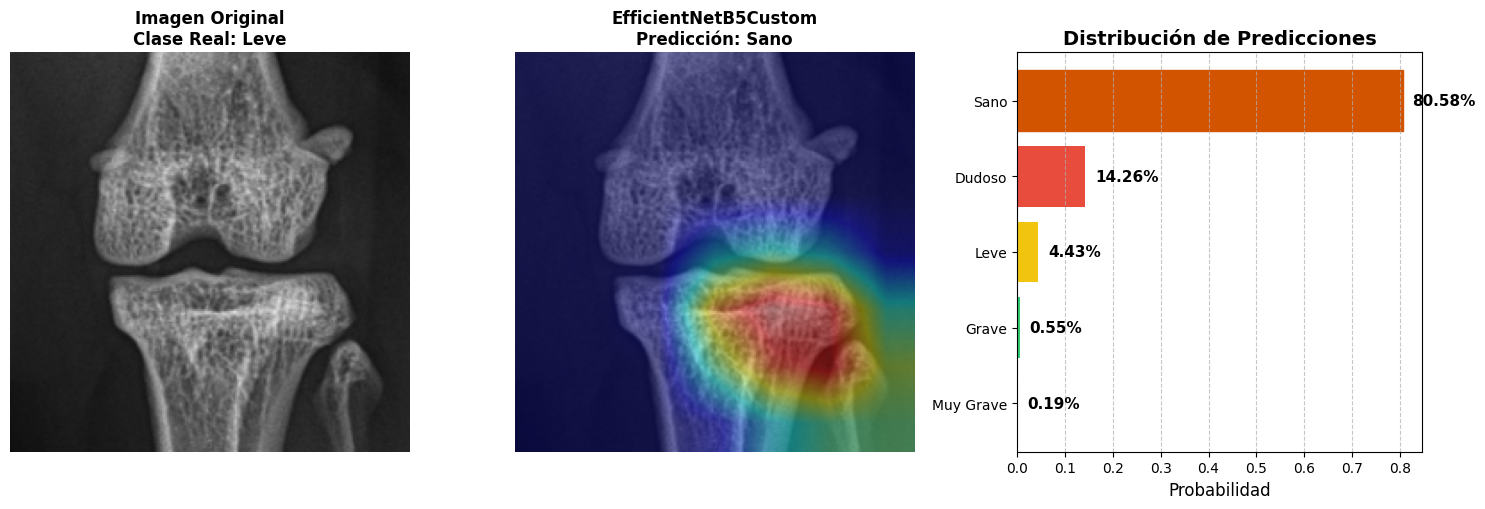

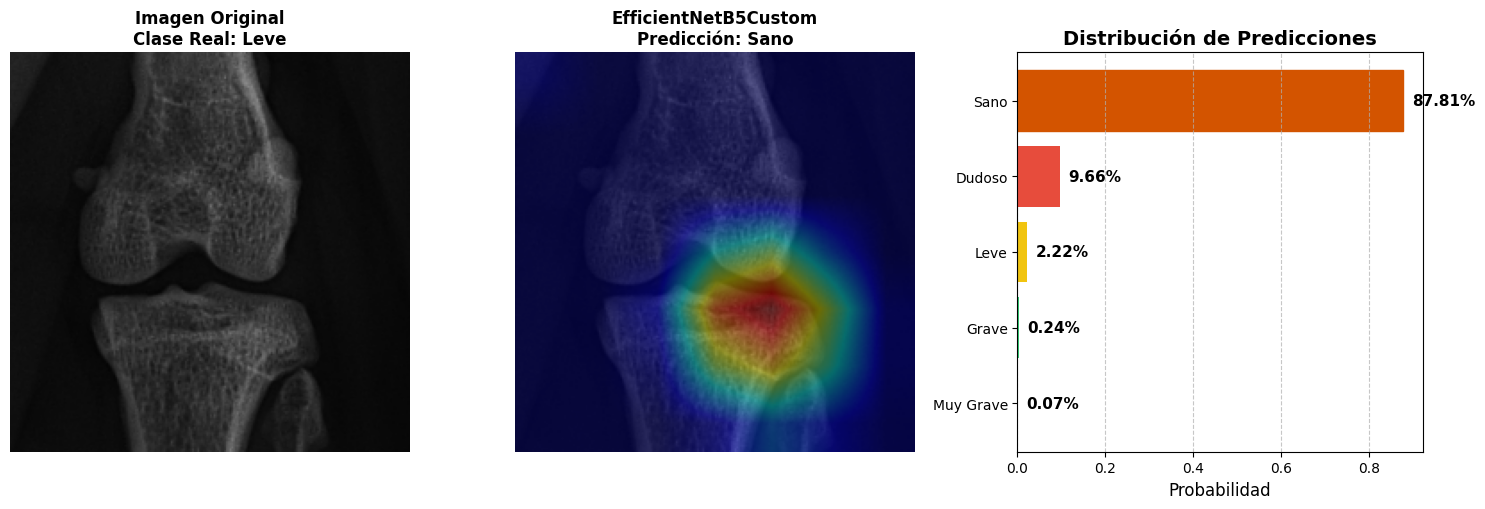

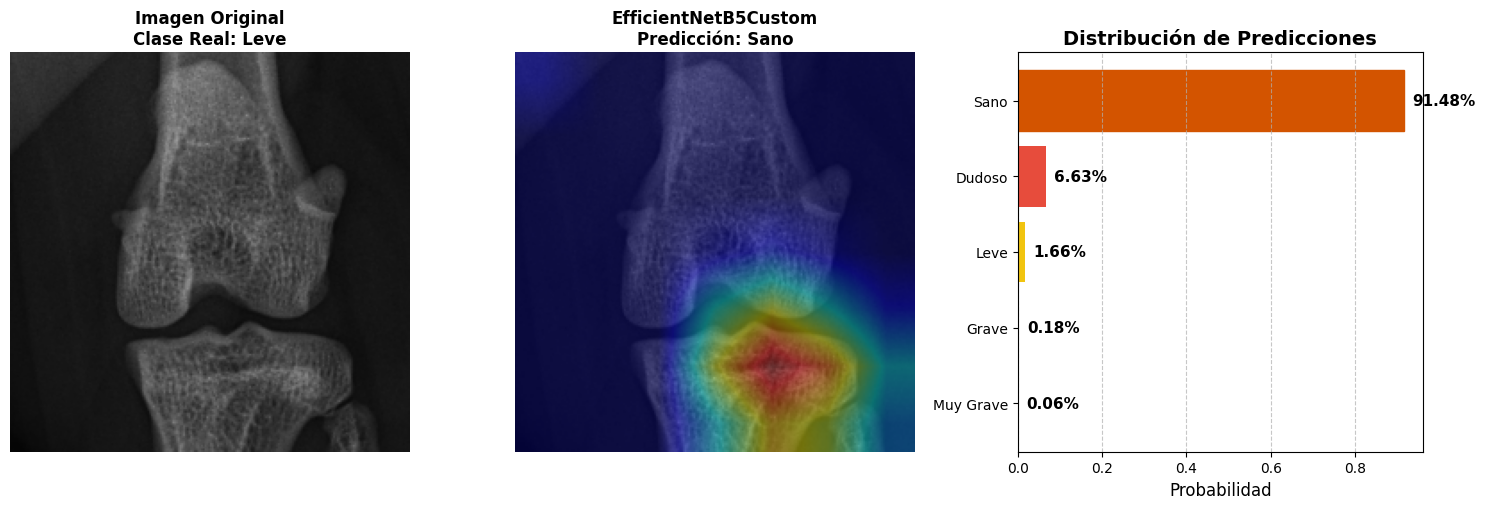

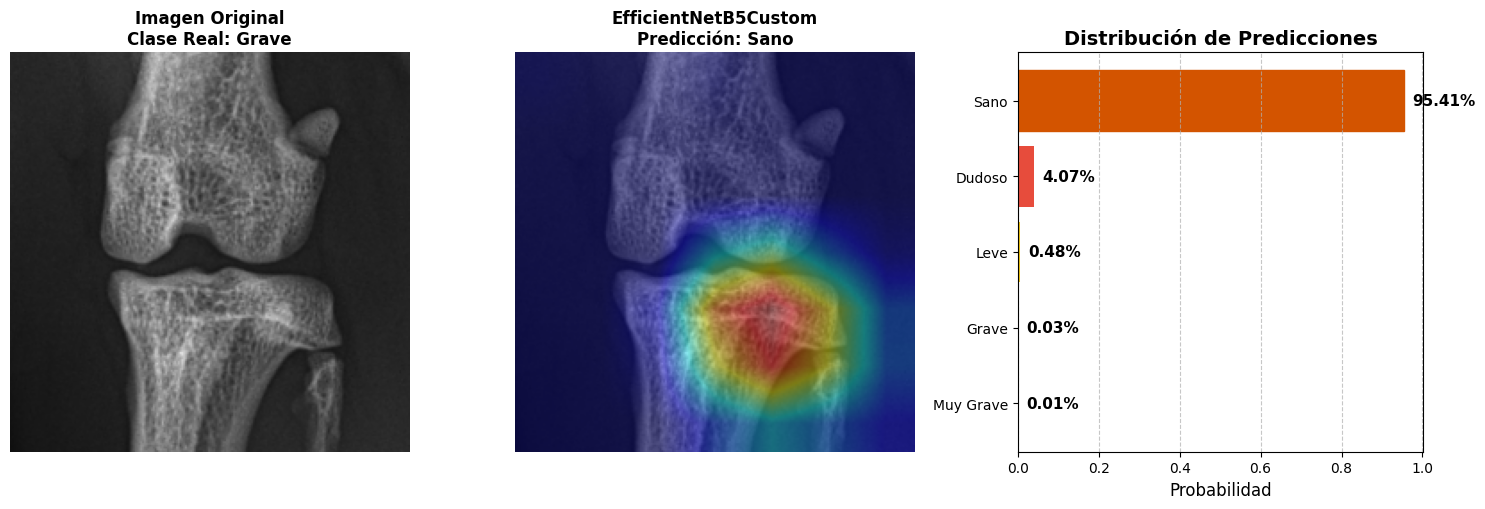

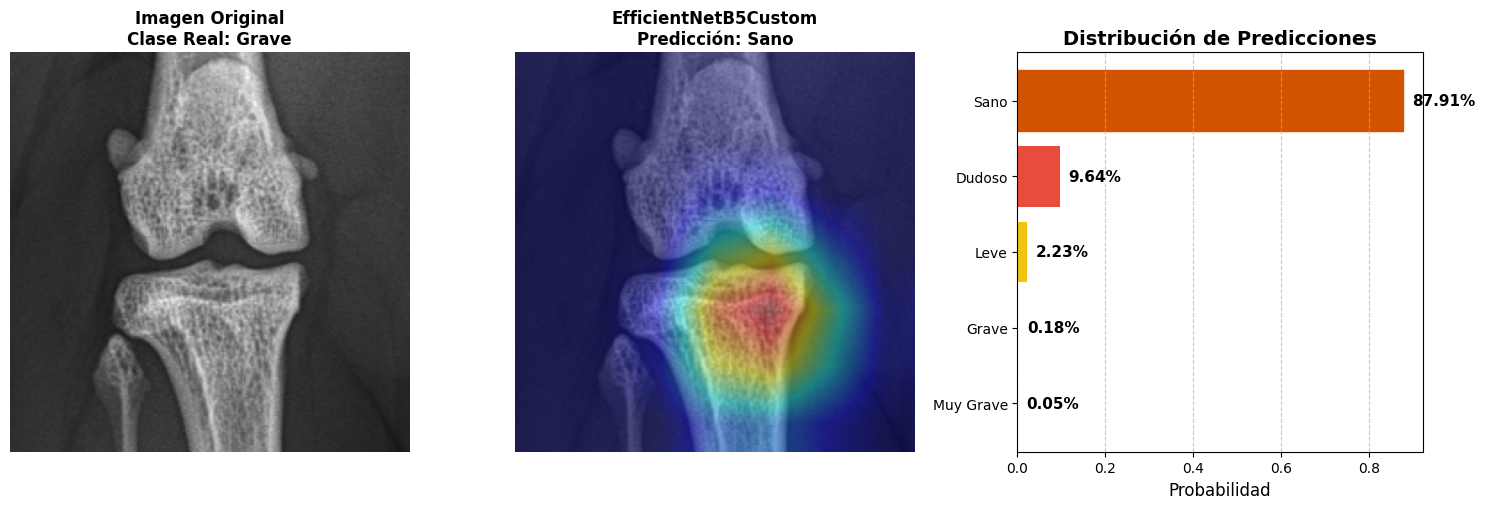

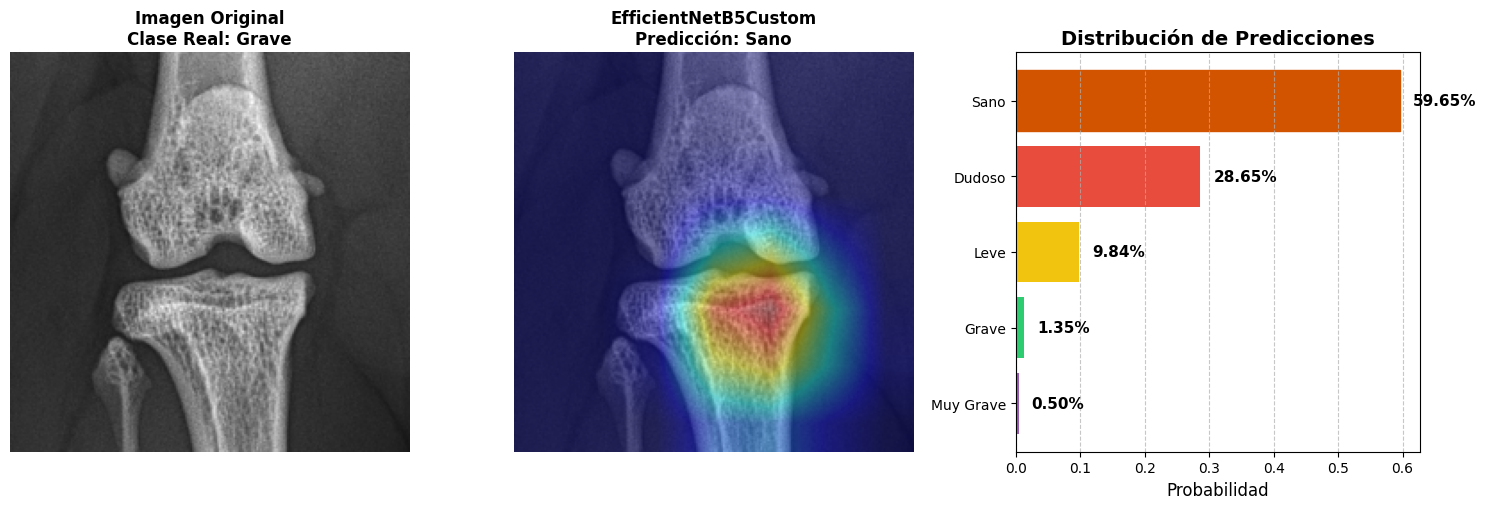

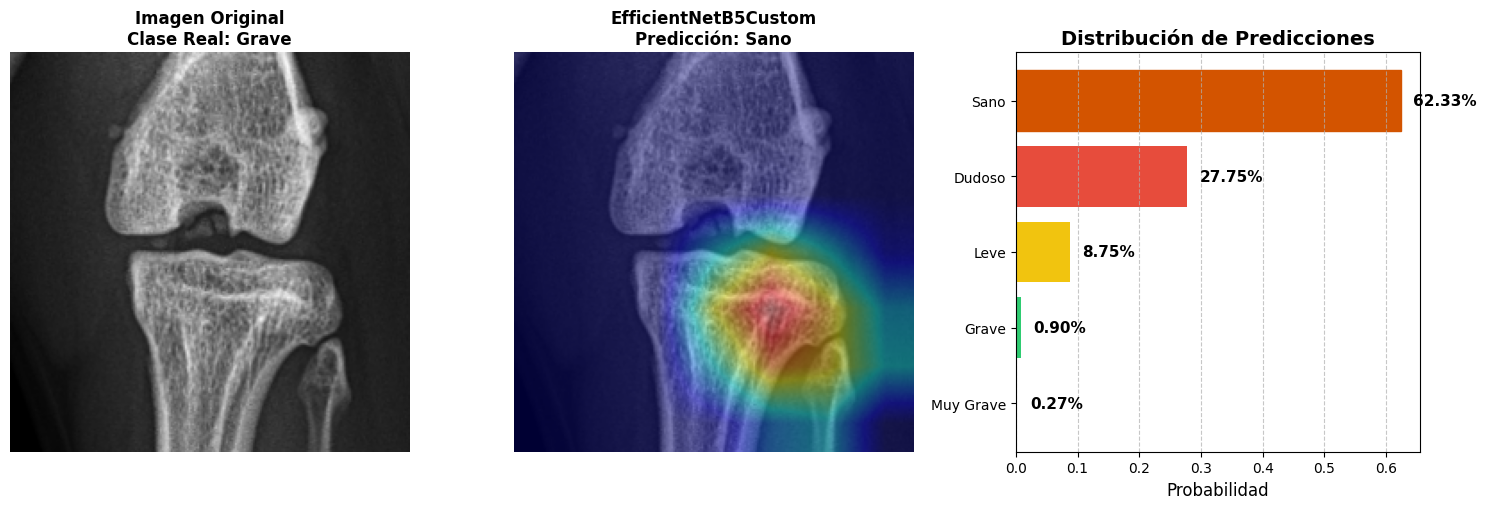

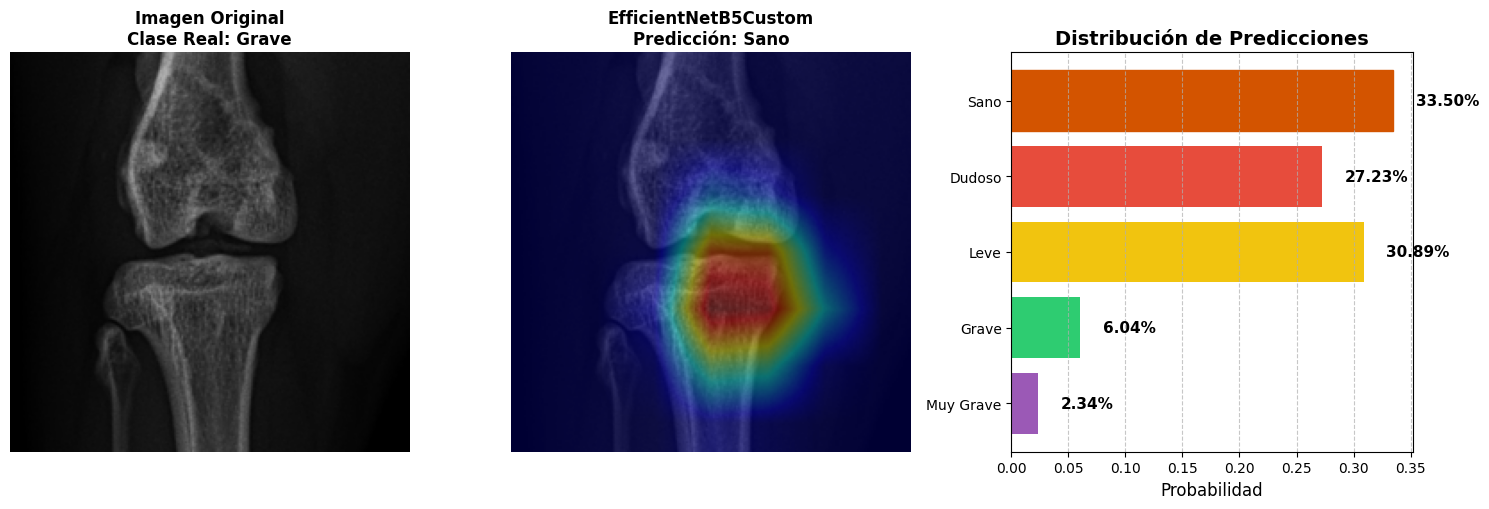

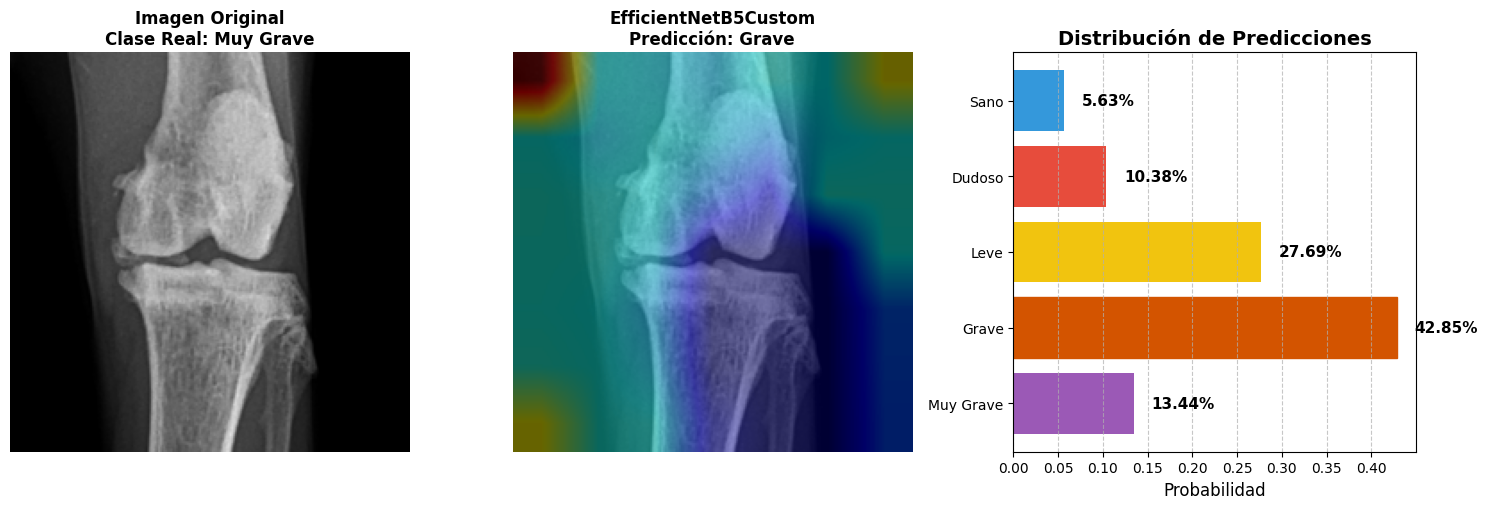

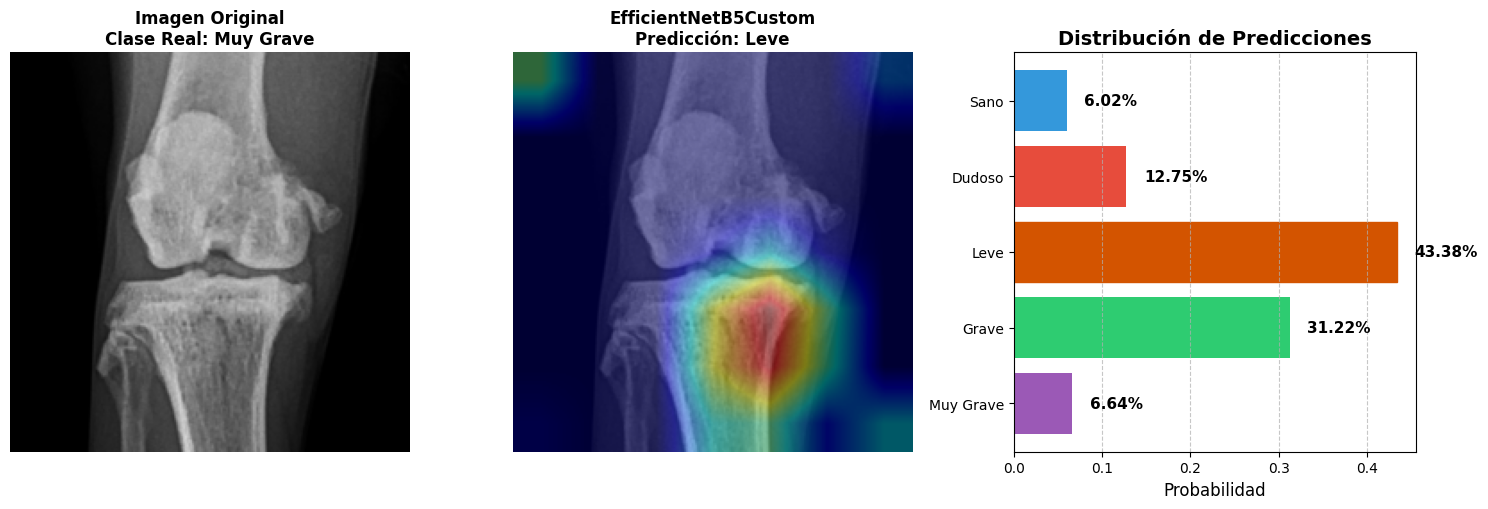

In [ ]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import *

# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

matrix_confusion = np.zeros((5, 5), dtype=int)  # Inicializar matriz de confusión
# Cargar el modelo
# Obtener rutas de imágenes y clases reales
dataset_path = "dataset/gatos/jpg/"
img_paths = []
for class_idx, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    i = 0
    for image_name in os.listdir(class_path):
        i += 1
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_idx))
        if i > 4:
            break

# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
        matrix_confusion[real_class][predicted_idx] += 1  # Actualizar matriz de confusión
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()



In [ ]:
grad_cam.generate_cam('data/val/COVID19/COVID19(1).jpg', 'grad_cam/COVID19(1).jpg')

In [ ]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import *
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from src.models.efficientnet import EfficientNetB5Custom
from src.grad_cam import GradCAM
model_state = torch.load('models/Medical Expert 1k/efficientnet/best_model_EfficientNetB5Custom_epoch_8.pt',map_location=torch.device('cpu'))
model_state_OAI = torch.load('models/OAI Mendeley/best_model_EfficientNetB5Custom_epoch_2.pt',map_location=torch.device('cpu'))
model = EfficientNetB5Custom(num_classes=5, pretrained=False)

model.load_state_dict(model_state_OAI)

model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

# Obtener rutas de imágenes y clases reales
dataset_path = MENDELEY_OAI_224_SPLIT_PATH + "/val"
dataset_path = MENDELEY_EXPERT1_SPLIT_PATH + "/val"
img_paths = []
num_por_clase = 3
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    i = num_por_clase
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_name))
        i -= 1
        if i == 0:
            break


# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        output = output.squeeze(0)  # Eliminar batch dimension
        probabilities = output  # Aplanar las salidas

        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase
    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()

